<a href="https://colab.research.google.com/github/momijizen/Coursera_Capstone/blob/main/Capstone_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analytics of rapid transit stations and venues neighborhood in Bangkok, Thailand.

#Table of Contents
1. Introduction
  - Background
  - Business Problem
2. Download and Explore Dataset
  - MRT Stations
  - BTS Stations
  - Foursquare
3. Methodology
  - Analyze Each Neighborhood
  - Cluster Neighborhoods
4. Result and Discussion
5. Conclusion

In [ ]:
import numpy as np
import pandas as pd
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from matplotlib.patches import Patch

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import preprocessing

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!pip install folium==0.5.0
import folium # plotting library

!pip install django  
from django.contrib.gis.geos import Polygon # convert an UTM coordinates into latitude and longitude values
from pprint import pprint

     |████████████████████████████████| 81kB 9.3MB/s 
  Created wheel for folium: filename=folium-0.5.0-cp37-none-any.whl size=76240 sha256=51510a64d9ae6438b06476044417b223d621947a74653050b62f2736b0321057
  Stored in directory: /root/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.5.0 which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 7.9MB 25.0MB/s 


In [ ]:
#add font thai
import matplotlib.font_manager as fm
font_list = fm.createFontList(['THSarabunNew.ttf'])
fm.fontManager.ttflist.extend(font_list)
# set font
plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#1. Introduction

##Background

rapid transit stations
DGA Open Government License
BTs 13 สิงหาคม 2563
mrt 13 สิงหาคม 2563


##Business Problem

#2. Download and Explore Dataset

##Download MRT Stations and BTS Stations Data

###MRT Stations Data

In [ ]:
!wget https://raw.githubusercontent.com/momijizen/Coursera_Capstone/main/bmrt_station.json

mrt_data = json.load(open('bmrt_station.json')) 

df = json_normalize(mrt_data["features"])
df.head()

--2021-05-26 05:32:11--  https://raw.githubusercontent.com/momijizen/Coursera_Capstone/main/bmrt_station.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5857 (5.7K) [text/plain]
Saving to: ‘bmrt_station.json’

bmrt_station.json   100%[===================>]   5.72K  --.-KB/s    in 0s      

2021-05-26 05:32:11 (51.7 MB/s) - ‘bmrt_station.json’ saved [5857/5857]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


type              id  ... properties.dcode properties.num_pass
0  Feature  bmrt_station.1  ...             1033              582654
1  Feature  bmrt_station.2  ...             1033             3710289
2  Feature  bmrt_station.3  ...             1030             2701979
3  Feature  bmrt_station.4  ...             1030             3945951
4  Feature  bmrt_station.5  ...             1030             4179222

[5 rows x 9 columns]

###BTS Stations Data

In [ ]:
!wget https://raw.githubusercontent.com/momijizen/Coursera_Capstone/main/bts_station.json
bts_data = json.load(open('bts_station.json'), encoding='utf-8') 

df = json_normalize(bts_data["features"])
df.head()

--2021-05-26 05:32:12--  https://raw.githubusercontent.com/momijizen/Coursera_Capstone/main/bts_station.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11341 (11K) [text/plain]
Saving to: ‘bts_station.json’

bts_station.json    100%[===================>]  11.08K  --.-KB/s    in 0s      

2021-05-26 05:32:12 (99.3 MB/s) - ‘bts_station.json’ saved [11341/11341]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


type  ... properties.num_pass
0  Feature  ...          11686236.0
1  Feature  ...           2715450.0
2  Feature  ...           3704520.0
3  Feature  ...           1161531.0
4  Feature  ...          13573102.0

[5 rows x 9 columns]

###Tranform the data into a pandas dataframe

In [ ]:
# define the dataframe columns
column_names = ['id', 'name_thai', 'location','num_passengers', 'coordinates_x', 'coordinates_y'] 

# instantiate the dataframe
df_raw = pd.DataFrame(columns=column_names)
df_raw

Empty DataFrame
Columns: [id, name_thai, location, num_passengers, coordinates_x, coordinates_y]
Index: []

In [ ]:
def get_features_data(data,type_station):
  global df_raw
  for data in data:
    id = data['id']
    name_thai = data['properties']['name']
    num_passengers = data['properties']['num_pass']
    location = data['properties']['location']
    coordinates = data['geometry']['coordinates']
    coordinates_x = coordinates[0]
    corrdinates_y = coordinates[1]
    type_station = type_station
    
    df_raw = df_raw.append({'id': id,
                            'name_thai': name_thai,
                            'num_passengers': num_passengers,
                            'location': location,
                            'coordinates_x': coordinates_x,
                            'coordinates_y': corrdinates_y,
                            'type_station': type_station}, ignore_index=True)

In [ ]:
get_features_data(mrt_data['features'],'MRT')
get_features_data(bts_data['features'],'BTS')

In [ ]:
df_raw

In [ ]:
df_raw.info()

Drop None lows in num_passengers column.

In [ ]:
df_raw.dropna(axis=0, inplace=True)

In [ ]:
df_raw.info()

##Data Wrangling

###Convert an UTM coordinates into latitude and langitude values

In [ ]:
coor = (df_raw[['coordinates_x','coordinates_y']]).to_numpy().tolist() 
#Polygon first and last coordinate should be identical (linear ring)
coor.append(coor[0])

In [ ]:
poly_thai = Polygon(coor, srid=32647)
poly_gps = poly_thai.transform(4326, clone=True) #4326
pprint(poly_gps.coords)

In [ ]:
df_lat_long = pd.DataFrame(poly_gps[0], columns=['longitude','latitude'])
df_lat_long

###Merge latitude and longitude columns

In [ ]:
df_station = df_raw.merge(df_lat_long, left_index=True, right_index=True)
df_station.drop(labels=['coordinates_x', 'coordinates_y'], axis=1, inplace=True)

In [ ]:
df_station

id                  name_thai  ...   longitude   latitude
0    bmrt_station.1               สถานีคลองเตย  ...  100.553813  13.722557
1    bmrt_station.2  สถานีศูนย์ประชุมสิริกิติ์  ...  100.560067  13.723742
2    bmrt_station.3               สถานีบางซื่อ  ...  100.539352  13.803132
3    bmrt_station.4            สถานีสวนจตุจักร  ...  100.554048  13.803829
4    bmrt_station.5              สถานีลาดพร้าว  ...  100.573501  13.806002
5    bmrt_station.6              สถานีสุทธิสาร  ...  100.574379  13.789037
6    bmrt_station.7            สถานีรัชดาภิเษก  ...  100.574443  13.799171
7    bmrt_station.8              สถานีห้วยขวาง  ...  100.573916  13.778992
8    bmrt_station.9             สถานีกำแพงเพชร  ...  100.547559  13.797790
9   bmrt_station.10              สถานีพระราม 9  ...  100.565204  13.757766
10  bmrt_station.11         สถานีศูนย์วัฒนธรรม  ...  100.571360  13.767282
11  bmrt_station.12              สถานีเพชรบุรี  ...  100.563144  13.748509
12  bmrt_station.13              สถานีสุขุมวิท  ...  100.561462  13.738456
13  bmrt_station.14               สถานีสามย่าน  ...  100.529506  13.732798
14  bmrt_station.15                  สถานีสีลม  ...  100.536449  13.729213
15  bmrt_station.16               สถานีลุมพินี  ...  100.545057  13.726313
16  bmrt_station.17              สถานีหัวลำโพง  ...  100.516966  13.737888
17  bmrt_station.18              สถานีพหลโยธิน  ...  100.560147  13.814152
18    bts_station.1                สถานีหมอชิต  ...  100.553787  13.802568
19    bts_station.2             สถานีสะพานควาย  ...  100.549689  13.793794
20    bts_station.3                สถานีอารีย์  ...  100.544616  13.779691
21    bts_station.4              สถานีสนามเป้า  ...  100.542052  13.772630
22    bts_station.5        สถานีอนุเสาวรีย์ชัย  ...  100.537046  13.762744
23    bts_station.6                 สถานีพญาไท  ...  100.533789  13.756932
24    bts_station.7               สถานีราชเทวี  ...  100.531546  13.751860
25    bts_station.8      สถานีสนามกีฬาแห่งชาติ  ...  100.529176  13.746444
26    bts_station.9                  สถานีสยาม  ...  100.534584  13.745528
27   bts_station.10               สถานีราชดำริ  ...  100.539431  13.739433
28   bts_station.11               สถานีศาลาแดง  ...  100.534360  13.728502
29   bts_station.12           สถานีช่องนนทรีย์  ...  100.529334  13.723754
30   bts_station.13             สถานีสุรศักดิ์  ...  100.521427  13.719201
31   bts_station.14           สถานีสะพานตากสิน  ...  100.514085  13.718792
32   bts_station.15                 สถานีชิดลม  ...  100.543158  13.744059
33   bts_station.16              สถานีเพลินจิต  ...  100.548879  13.743020
34   bts_station.17                  สถานีนานา  ...  100.555406  13.740505
35   bts_station.18                  สถานีอโศก  ...  100.560352  13.737020
36   bts_station.19             สถานีพร้อมพงษ์  ...  100.569716  13.730415
37   bts_station.20               สถานีทองหล่อ  ...  100.578513  13.724212
38   bts_station.21                สถานีเอกมัย  ...  100.585096  13.719520
39   bts_station.22               สถานีพระโขนง  ...  100.591214  13.715154
40   bts_station.23               สถานีอ่อนนุช  ...  100.600990  13.705617
41   bts_station.24            สถานีกรุงธนบุรี  ...  100.502614  13.720870
42   bts_station.25           สถานีวงเวียนใหญ่  ...  100.495146  13.721017
43   bts_station.26                สถานีบางจาก  ...  100.605338  13.696728
44   bts_station.27               สถานีปุณวิถี  ...  100.608985  13.689267
45   bts_station.28               สถานีอุดมสุข  ...  100.609453  13.679859
46   bts_station.29                 สถานีบางนา  ...  100.604653  13.668132
47   bts_station.30                สถานีแบริ่ง  ...  100.601752  13.661061

[48 rows x 7 columns]

###Normalize amount of passenger data in num_passenger column

In [ ]:
df_station['num_passengers'] = (df_station['num_passengers']-df_station['num_passengers'].min())/(df_station['num_passengers'].max() - df_station['num_passengers'].min())

In [ ]:
df_station.head()

id                  name_thai  ...   longitude   latitude
0  bmrt_station.1               สถานีคลองเตย  ...  100.553813  13.722557
1  bmrt_station.2  สถานีศูนย์ประชุมสิริกิติ์  ...  100.560067  13.723742
2  bmrt_station.3               สถานีบางซื่อ  ...  100.539352  13.803132
3  bmrt_station.4            สถานีสวนจตุจักร  ...  100.554048  13.803829
4  bmrt_station.5              สถานีลาดพร้าว  ...  100.573501  13.806002

[5 rows x 7 columns]

###Create map of Train Stations

Use geopy library to get the latitude and longitude values of Bangkok City.

In [ ]:
address = 'Siam station Bangkok, Thailand' 

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

13.7560598 100.490126


In [ ]:
# create map of Train Stations using latitude and longitude values
map_station = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(df_station['latitude'], df_station['longitude'], df_station['name_thai']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_station)  
    folium.Circle([lat, lng], radius=500, color='blue', fill=False).add_to(map_station)
    
map_station

###Define Foursquare Credentials and Version

In [ ]:
CLIENT_ID = 'M1QUR2OTW2YEYMXNYIF3AOIRNPCTUXFGQQCXAV3HGOTXEAO4' # your Foursquare ID
CLIENT_SECRET = 'XRK0T0KEG1UDGCU5YEGXMXR3QIRU02JZY3QOBN0BYLNPS52N' # your Foursquare Secret
ACCESS_TOKEN = '1KDLE0AX2IH4RBQL5P41P0IW4TFKATXNH5TO1VZPVUCIKN3Q' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 200
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M1QUR2OTW2YEYMXNYIF3AOIRNPCTUXFGQQCXAV3HGOTXEAO4
CLIENT_SECRET:XRK0T0KEG1UDGCU5YEGXMXR3QIRU02JZY3QOBN0BYLNPS52N


###Create a function to find the venues of all train station neighborhoods.

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Distance', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
df_venues = getNearbyVenues(names=df_station['name_thai'],
                         latitudes= df_station['latitude'], 
                         longitudes= df_station['longitude']
                         )

In [ ]:
print(df_venues.shape)
df_venues.head(10)

(2461, 9)


Neighborhood  Neighborhood Latitude  ...  Venue Distance     Venue Category
0  สถานีคลองเตย              13.722557  ...             134       Noodle House
1  สถานีคลองเตย              13.722557  ...             299    Thai Restaurant
2  สถานีคลองเตย              13.722557  ...             145    Thai Restaurant
3  สถานีคลองเตย              13.722557  ...             298       Noodle House
4  สถานีคลองเตย              13.722557  ...             250       Noodle House
5  สถานีคลองเตย              13.722557  ...             163     History Museum
6  สถานีคลองเตย              13.722557  ...             391    Thai Restaurant
7  สถานีคลองเตย              13.722557  ...             107    Badminton Court
8  สถานีคลองเตย              13.722557  ...             240       Noodle House
9  สถานีคลองเตย              13.722557  ...              38  Convenience Store

[10 rows x 9 columns]

###Drop Duplicated in Venues column

In [ ]:
df_venues = df_venues.sort_values(by='Venue Distance').drop_duplicates(subset=['Id'],keep='first' )

In [ ]:
df_venues.shape

(2168, 9)

In [ ]:
df_venues.loc[df_venues.duplicated(subset=['Id'],keep=False)].head(20)

Empty DataFrame
Columns: [Neighborhood, Neighborhood Latitude, Neighborhood Longitude, Id, Venue, Venue Latitude, Venue Longitude, Venue Distance, Venue Category]
Index: []

###Drop rows contains Train Station, Metro Station in Venue Category column

In [ ]:
df_venues.drop(df_venues[df_venues['Venue Category'].str.contains('Train Station')].index.values, axis=0, inplace=True)

In [ ]:
df_venues.drop(df_venues[df_venues['Venue Category'].str.contains('Metro Station')].index.values, axis=0, inplace=True)

In [ ]:
df_venues.shape

(2140, 9)

In [ ]:
len(df_venues['Venue Category'].unique())

232

#3. Methodology

##Analyze ​Data

###Amount of passenger per station

<Figure size 432x288 with 0 Axes>

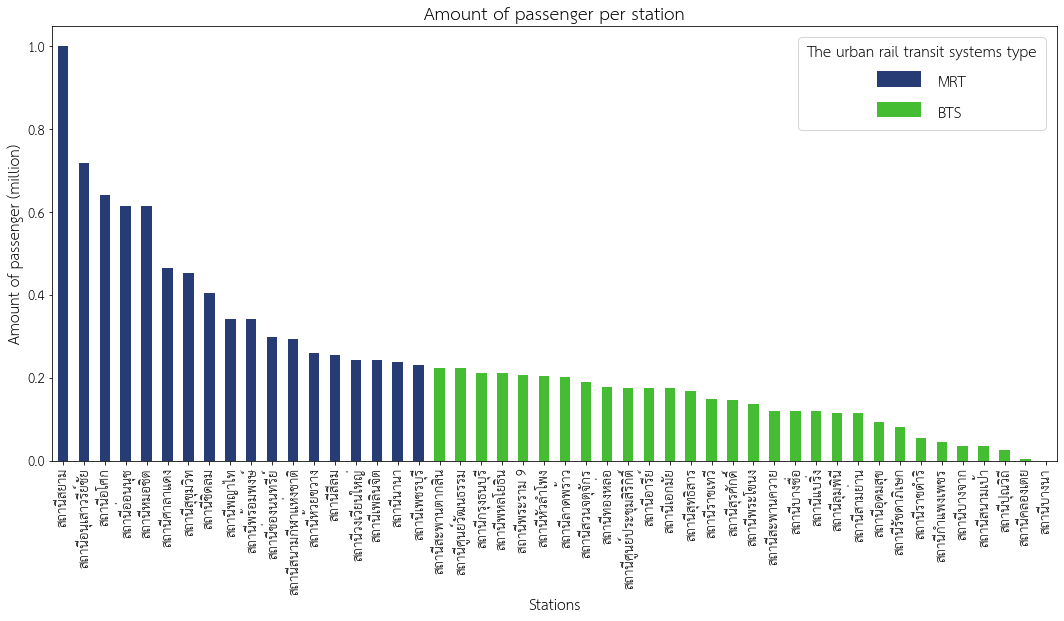

In [ ]:
plt.figure()
plt.rcParams.update({'font.size': 22}) # must set in top
colours = {"MRT": "#273c75", "BTS": "#44bd32"}
ax = df_station.sort_values(by='num_passengers',ascending=False).plot(
    kind='bar', x='name_thai', y='num_passengers', figsize=(18,8), color=df_station['type_station'].replace(colours)
    ).legend(
      [
        Patch(facecolor=colours['MRT']),
        Patch(facecolor=colours['BTS'])
      ], ["MRT", "BTS"]
    )

plt.title('Amount of passenger per station')
plt.xlabel('Stations')
plt.ylabel('Amount of passenger (million)')
ax.set_title('The urban rail transit systems type')


###Relationship between amount of passengers and amount of venues neighborhood

In [ ]:
df_station = df_station.merge(df_venues.groupby(by='Neighborhood').count().reset_index()[['Neighborhood','Venue']],left_on='name_thai', right_on='Neighborhood' )

In [ ]:
df_station['num_venue'] = (df_station['Venue']-df_station['Venue'].min())/(df_station['Venue'].max() - df_station['Venue'].min())

Text(468.01587301587307, 0.5, 'Number of Passengers')

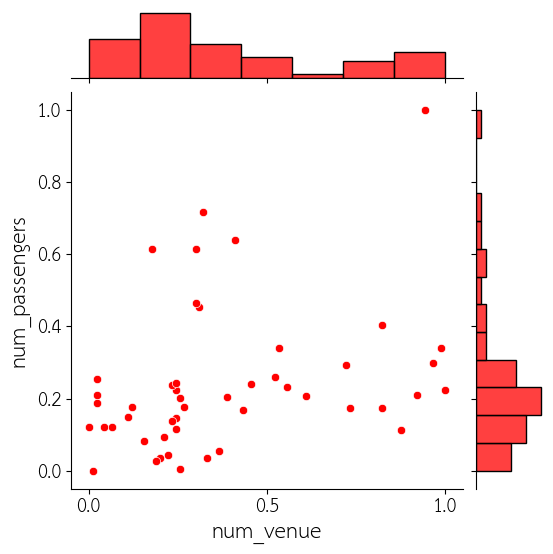

In [ ]:
plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})
sns.jointplot(x=df_station["num_venue"], y=df_station["num_passengers"],color='red', kind='scatter')
plt.xlabel('Number of Venue')
plt.ylabel('Number of Passengers')


###Number of Venue Category

Text(0, 0.5, 'Number of Venue Category')

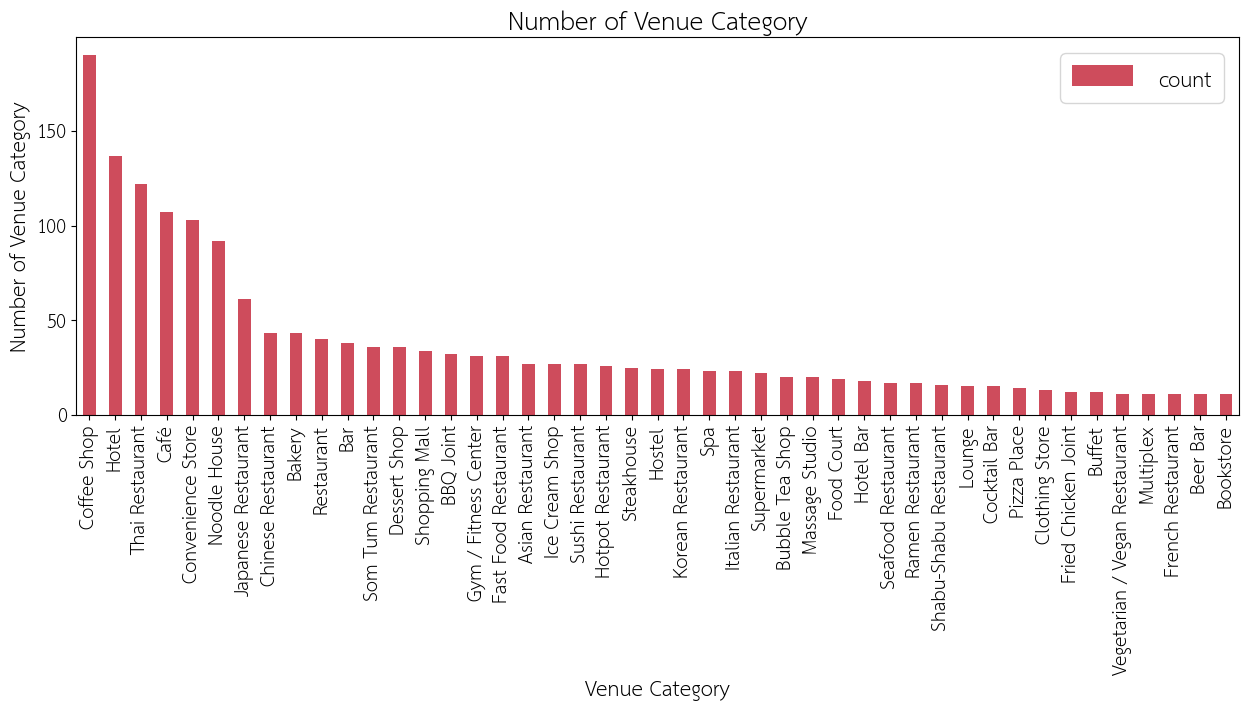

In [ ]:
category = df_venues.groupby(by='Venue Category')['Venue Category'].count().reset_index(name='count').sort_values(by='count', ascending=False)
category[category['count'] > 10].plot(x='Venue Category', kind='bar', figsize=(15,5), color='#CE4C5C' )
plt.title('Number of Venue Category')
plt.xlabel('Venue Category')
plt.ylabel('Number of Venue Category')

###Map Station Neighborhood with Venues

In [ ]:

venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around the Conrad Hotel

  #add the Train Station as blue circle markers
for lat, lng, label in zip(df_venues['Venue Latitude'], df_venues['Venue Longitude'], df_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FD687A',
        fill_opacity=0.5,
        parse_html=False).add_to(venues_map)  

  #add the Train Station as blue circle markers
for lat, lng, label in zip(df_station['latitude'], df_station['longitude'], df_station['name_thai']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(venues_map)  
    folium.Circle([lat, lng], radius=500, color='blue', fill=False).add_to(venues_map)    
    
  # display map
venues_map

##Clustering K-Means

In [ ]:
df_venues.groupby(by='Venue Category').count()

Neighborhood  ...  Venue Distance
Venue Category                     ...                
Accessories Store               4  ...               4
Airport Terminal                1  ...               1
American Restaurant             2  ...               2
Aquarium                        1  ...               1
Arcade                          2  ...               2
...                           ...  ...             ...
Wine Bar                        3  ...               3
Women's Store                   2  ...               2
Yakitori Restaurant             1  ...               1
Yoga Studio                     9  ...               9
Yoshoku Restaurant              3  ...               3

[232 rows x 8 columns]

In [ ]:
venues_onehot = pd.get_dummies(df_venues['Venue Category'])
venues_onehot

Accessories Store  Airport Terminal  ...  Yoga Studio  Yoshoku Restaurant
624                   0                 0  ...            0                   0
954                   0                 0  ...            0                   0
962                   0                 0  ...            0                   0
953                   0                 0  ...            0                   0
2013                  0                 0  ...            0                   0
...                 ...               ...  ...          ...                 ...
1812                  0                 0  ...            0                   0
1932                  0                 0  ...            0                   0
1041                  0                 0  ...            0                   0
1217                  0                 0  ...            0                   0
1095                  0                 0  ...            0                   0

[2140 rows x 232 columns]

Add neighborhood column back to dataframe

In [ ]:
venues_onehot['Neighborhood'] = df_venues['Neighborhood']
venues_onehot.head()

Accessories Store  Airport Terminal  ...  Yoshoku Restaurant    Neighborhood
624                   0                 0  ...                   0    สถานีสามย่าน
954                   0                 0  ...                   0     สถานีหมอชิต
962                   0                 0  ...                   0     สถานีหมอชิต
953                   0                 0  ...                   0     สถานีหมอชิต
2013                  0                 0  ...                   0  สถานีพร้อมพงษ์

[5 rows x 233 columns]

In [ ]:
venues_grouped = venues_onehot.groupby(by='Neighborhood').mean().reset_index()
venues_grouped

Neighborhood  ...  Yoshoku Restaurant
0             สถานีกรุงธนบุรี  ...            0.000000
1              สถานีกำแพงเพชร  ...            0.000000
2                สถานีคลองเตย  ...            0.000000
3                  สถานีชิดลม  ...            0.000000
4            สถานีช่องนนทรีย์  ...            0.000000
5                สถานีทองหล่อ  ...            0.000000
6                   สถานีนานา  ...            0.000000
7                 สถานีบางจาก  ...            0.000000
8                สถานีบางซื่อ  ...            0.000000
9                  สถานีบางนา  ...            0.000000
10               สถานีปุณวิถี  ...            0.000000
11                 สถานีพญาไท  ...            0.000000
12              สถานีพระราม 9  ...            0.000000
13               สถานีพระโขนง  ...            0.000000
14             สถานีพร้อมพงษ์  ...            0.000000
15              สถานีพหลโยธิน  ...            0.010753
16            สถานีรัชดาภิเษก  ...            0.000000
17               สถานีราชดำริ  ...            0.000000
18               สถานีราชเทวี  ...            0.000000
19              สถานีลาดพร้าว  ...            0.000000
20               สถานีลุมพินี  ...            0.000000
21           สถานีวงเวียนใหญ่  ...            0.000000
22               สถานีศาลาแดง  ...            0.027027
23  สถานีศูนย์ประชุมสิริกิติ์  ...            0.000000
24         สถานีศูนย์วัฒนธรรม  ...            0.000000
25      สถานีสนามกีฬาแห่งชาติ  ...            0.000000
26              สถานีสนามเป้า  ...            0.000000
27                  สถานีสยาม  ...            0.000000
28            สถานีสวนจตุจักร  ...            0.000000
29             สถานีสะพานควาย  ...            0.000000
30           สถานีสะพานตากสิน  ...            0.000000
31               สถานีสามย่าน  ...            0.000000
32                  สถานีสีลม  ...            0.000000
33              สถานีสุขุมวิท  ...            0.000000
34              สถานีสุทธิสาร  ...            0.000000
35             สถานีสุรศักดิ์  ...            0.000000
36                สถานีหมอชิต  ...            0.000000
37              สถานีหัวลำโพง  ...            0.000000
38              สถานีห้วยขวาง  ...            0.000000
39        สถานีอนุเสาวรีย์ชัย  ...            0.000000
40                สถานีอารีย์  ...            0.000000
41               สถานีอุดมสุข  ...            0.000000
42                  สถานีอโศก  ...            0.000000
43               สถานีอ่อนนุช  ...            0.000000
44              สถานีเพชรบุรี  ...            0.000000
45              สถานีเพลินจิต  ...            0.000000
46                สถานีเอกมัย  ...            0.011905
47                สถานีแบริ่ง  ...            0.000000

[48 rows x 233 columns]

In [ ]:
num_top_venues = 5

for hood in venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = venues_grouped[venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----สถานีกรุงธนบุรี----
               venue  freq
0  Convenience Store  0.42
1       Noodle House  0.17
2            Factory  0.08
3        Coffee Shop  0.08
4    Badminton Court  0.08


----สถานีกำแพงเพชร----
                           venue  freq
0                    Coffee Shop  0.13
1             Som Tum Restaurant  0.13
2                Thai Restaurant  0.10
3                           Café  0.10
4  Vegetarian / Vegan Restaurant  0.07


----สถานีคลองเตย----
               venue  freq
0       Noodle House  0.24
1    Thai Restaurant  0.15
2  Convenience Store  0.12
3          Cafeteria  0.03
4         Toll Plaza  0.03


----สถานีชิดลม----
         venue  freq
0  Coffee Shop  0.10
1        Hotel  0.10
2  Yoga Studio  0.05
3       Buffet  0.04
4          Spa  0.04


----สถานีช่องนนทรีย์----
                  venue  freq
0           Coffee Shop  0.11
1                  Café  0.08
2  Gym / Fitness Center  0.07
3                 Hotel  0.06
4       Thai Restaurant  0.05


----สถานีทองหล

First, let's write a function to sort the venues in descending order.


In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood  ... 10th Most Common Venue
0   สถานีกรุงธนบุรี  ...             Eye Doctor
1    สถานีกำแพงเพชร  ...           Night Market
2      สถานีคลองเตย  ...                 Bistro
3        สถานีชิดลม  ...    Fried Chicken Joint
4  สถานีช่องนนทรีย์  ...                    Bar

[5 rows x 11 columns]

###Optimal number of clusters 

In [ ]:
test_clustering = venues_grouped

In [ ]:
test_clustering = venues_grouped.join(df_station['Venue'])

In [ ]:
test_clustering = test_clustering.drop('Neighborhood', 1)

In [ ]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(test_clustering)
    Sum_of_squared_distances.append(km.inertia_)

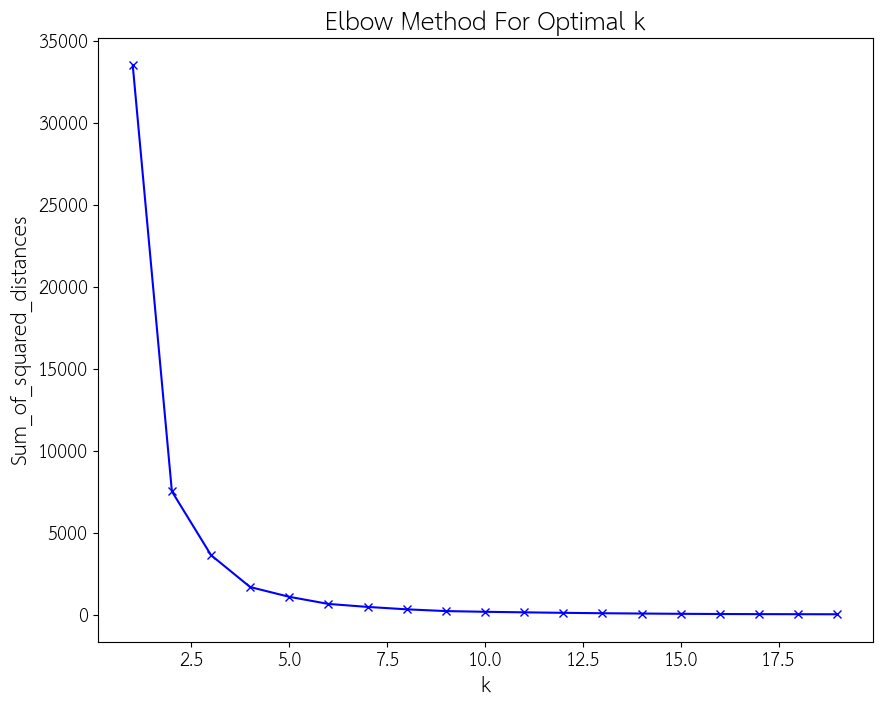

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

###Cluster Neighborhoods

In [ ]:
# set number of clusters
kclusters = 5
venues_grouped_clustering = venues_grouped
venues_grouped_clustering = venues_grouped_clustering.join(df_station['Venue'])
venues_grouped_clustering = venues_grouped_clustering.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 2, 1, 3, 1, 3, 1, 3], dtype=int32)

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



In [ ]:
station_merged = df_venues


In [ ]:

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
station_merged = station_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on=('Neighborhood'))

station_merged.head() # check the last columns!

Neighborhood  ...  10th Most Common Venue
624     สถานีสามย่าน  ...           Shopping Mall
954      สถานีหมอชิต  ...          Clothing Store
962      สถานีหมอชิต  ...          Clothing Store
953      สถานีหมอชิต  ...          Clothing Store
2013  สถานีพร้อมพงษ์  ...              Restaurant

[5 rows x 20 columns]

In [ ]:
station_merged.to_csv('station_kcurster.csv',encoding='utf-8-sig')

###Visualize the resulting clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(station_merged['Neighborhood Latitude'], station_merged['Neighborhood Longitude'], station_merged['Neighborhood'], station_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#4. Result and Discussion


In [ ]:
station_merged.loc[station_merged['Cluster Labels'] == 0, station_merged.columns[[1] + list(range(5, station_merged.shape[1]))]]

Neighborhood Latitude  ...  10th Most Common Venue
269               13.778992  ...                    Café
1353              13.746444  ...          Soccer Stadium
1351              13.746444  ...          Soccer Stadium
1270              13.746444  ...          Soccer Stadium
1355              13.746444  ...          Soccer Stadium
...                     ...  ...                     ...
1341              13.746444  ...          Soccer Stadium
787               13.726313  ...                  Buffet
750               13.729213  ...             Coffee Shop
789               13.726313  ...                  Buffet
1340              13.746444  ...          Soccer Stadium

[176 rows x 16 columns]

In [ ]:
station_merged.loc[station_merged['Cluster Labels'] == 1, station_merged.columns[[1] + list(range(5, station_merged.shape[1]))]]

Neighborhood Latitude  ...  10th Most Common Venue
624               13.732798  ...           Shopping Mall
2289              13.705617  ...                    Café
822               13.737888  ...            Dessert Shop
1135              13.762744  ...              Restaurant
152               13.789037  ...             Flea Market
...                     ...  ...                     ...
685               13.732798  ...           Shopping Mall
1874              13.743020  ...                    Café
674               13.732798  ...           Shopping Mall
1932              13.740505  ...    Ethiopian Restaurant
1041              13.779691  ...               BBQ Joint

[940 rows x 16 columns]

In [ ]:
station_merged.loc[station_merged['Cluster Labels'] == 2, station_merged.columns[[1] + list(range(5, station_merged.shape[1]))]]

Neighborhood Latitude  ...  10th Most Common Venue
2013              13.730415  ...              Restaurant
2414              13.679859  ...              Steakhouse
403               13.767282  ...      Chinese Restaurant
2431              13.679859  ...              Steakhouse
130               13.806002  ...           Shopping Mall
...                     ...  ...                     ...
466               13.767282  ...      Chinese Restaurant
2107              13.730415  ...              Restaurant
2109              13.730415  ...              Restaurant
1811              13.744059  ...     Fried Chicken Joint
1812              13.744059  ...     Fried Chicken Joint

[502 rows x 16 columns]

In [ ]:
station_merged.loc[station_merged['Cluster Labels'] == 3, station_merged.columns[[1] + list(range(5, station_merged.shape[1]))]]

Neighborhood Latitude  ...  10th Most Common Venue
2359              13.696728  ...                    Food
2111              13.724212  ...     American Restaurant
555               13.738456  ...                Sake Bar
1383              13.745528  ...           Movie Theater
1668              13.719201  ...              Hotel Pool
...                     ...  ...                     ...
1201              13.756932  ...      Som Tum Restaurant
1686              13.719201  ...              Hotel Pool
49                13.723742  ...         Bubble Tea Shop
1225              13.756932  ...      Som Tum Restaurant
1217              13.756932  ...      Som Tum Restaurant

[341 rows x 16 columns]

#5. Conclusion

#Save CSV File

In [ ]:
venues.to_csv('venues.csv',encoding='utf-8-sig')

In [ ]:
df_station.to_csv('stations.csv', encoding='utf-8-sig')

## tg

In [ ]:
  #add the Train Station as blue circle markers
for lat, lng, label in zip(df_station['latitude'], df_station['longitude'], df_station['name_thai']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(venues_map)  
    folium.Circle([lat, lng], radius=250, color='blue', fill=False).add_to(venues_map)

In [ ]:
venues_map